In [113]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

import statsmodels.tsa.stattools as sms

import mean_reversion as mr
import optimize
import portfolio
import returns
import strategies
import util

%matplotlib inline

In [260]:
def bollinger_mean_revert_fit(x, y):
    strategy = lambda lookback: \
        strategies.rolling_hedge_mean_revert_strategy(x, y, lookback)
    
    return {
        'lookback': optimize.vs_sharpe(
            'lookback', [5, 10, 15, 20, 25, 30], strategy)
    }
        
def bollinger_mean_revert(x, y, lookback=None):
    if lookback is None:
        lookback = bollinger_mean_revert_fit(x, y)['lookback']
    
    # Setup mean reversion portfolio to use for tradable zScore
    strategy = strategies.rolling_hedge_mean_revert_strategy
    (prices, weights, units) = strategy(x, y, lookback)
    port = portfolio.portfolio_price(prices, weights)
    
    # Ok, now let's look at the half-life of this portfolio, this needs to be low (under 30)
    # TODO: Test this? Throw it out if it doesn't meet standard?
    halflife = mr.halflife(port)
    cadf = sms.adfuller(port)[0]
    hurst = mr.hurst_exponent(port.pct_change().fillna(0))[0]
    
    # Collect zScore and theoretical results in the form of a sharpe ratio
    zScore = util.rolling_z_score(port, lookback)
    rets = portfolio.portfolio_returns(universe, weights, -zScore)
    theoretical_sharpe = returns.annual_sharpe(rets['returns'])
    
    # Collect units of this portfolio according to bollinger band strategy (buying and selling
    # against the given zScore)    
    units = strategies.bollinger_band_units(zScore, entryZScore=1.0, exitZScore=0.0)
    results = portfolio.portfolio_returns(prices, weights, units)

    results.update({
        'lookback': lookback,
        'halflife': halflife,
        'cadf': cadf,
        'hurst': hurst,
        'theoretical_sharpe': theoretical_sharpe,
        'units': units
    })
    
    results.update(
        returns.report(results['returns']))
    
    results.update(
        strategies.report(units))
    
    return results

def score_strategy(strategy_results):
    return returns.annual_sharpe(strategy_results['returns'])

In [210]:
start_dt = datetime.datetime(2015, 1, 1)
end_dt = datetime.datetime(2015, 12, 31)

# Interesting:
# USO, EWC, lookback=25, entryZScore=2, exitZScore=1, leverage=2
# DBC, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, EWA, lookback=15, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# * DBO, DBC, lookback=15, entryZScore=1.4, exitZScore=0, 2012-12-11 -> 2015-12-31
# * GLD, DBC, lookback=10, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# EWC, DJP, lookback=10, entryZScore=2.0, exitZScore=0.6, 2012-12-11 -> 2015-12-31


def fetch(ticker):
    global start_dt, end_dt
    return web.DataReader(ticker, 'yahoo', start_dt, end_dt)['Adj Close']

#SPY = fetch("SPY")
#DIA = fetch("DIA")
#QQQ = fetch("QQQ")
#IWM = fetch("IWM")
GLD = fetch("GLD")
USO = fetch("USO")
#DBO = fetch("DBO")
#EWA = fetch("EWA")
EWC = fetch("EWC")
DBC = fetch("DBC")
DJP = fetch("DJP")
#UNG = fetch("UNG")


In [261]:
reload(optimize)
reload(strategies)
reload(portfolio)
reload(returns)

<module 'returns' from 'returns.pyc'>

2015
        Total return: 0.410
        Sharpe ratio: 1.95
        APR: 0.462
        Drawdown: -0.17
        Max Time in Drawdown: 166
    


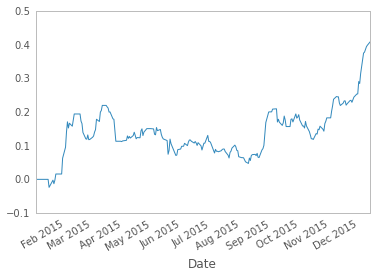

In [273]:
strategy_results = bollinger_mean_revert(GLD, USO)
#score_strategy(b_rets)
returns.cumret(strategy_results['returns']).plot()
print returns.report_str(strategy_results['returns'], "2015")

In [274]:
strategy_results['lookback']

10

In [282]:
def explore(x, y, xname="x", yname="y", lookback=None):
    print '-' * 80
    print 'Bollinger Band Mean Reversion Strategy: %s vs %s' % (xname, yname)
    print '-' * 80
    print
    print
    results = bollinger_mean_revert(x, y, lookback=lookback)
    print returns.report_str(results['returns'], "Returns")
    print strategies.report_str(results['units'], "Trades")
    print score_strategy(results)
    print
    print

In [283]:
explore(GLD, DBC, xname="GLD", yname="DBC", lookback=10)
explore(USO, EWC, xname="USO", yname="EWC", lookback=10)
explore(GLD, USO, xname="GLD", yname="USO", lookback=10)
explore(EWC, DJP, xname="EWC", yname="DJP", lookback=10)

--------------------------------------------------------------------------------
Bollinger Band Mean Reversion Strategy: GLD vs DBC
--------------------------------------------------------------------------------


Returns
        Total return: 0.184
        Sharpe ratio: 1.68
        APR: 0.201
        Drawdown: -0.08
        Max Time in Drawdown: 133
    
Trades
        Total trades: 40
        Trades per day: 0.17
        Days per trade: 6.00
        Percent time in market: 0.81
        Bars in market: 195
    
1.67876232392


--------------------------------------------------------------------------------
Bollinger Band Mean Reversion Strategy: USO vs EWC
--------------------------------------------------------------------------------


Returns
        Total return: 0.108
        Sharpe ratio: 0.95
        APR: 0.122
        Drawdown: -0.14
        Max Time in Drawdown: 89
    
Trades
        Total trades: 43
        Trades per day: 0.18
        Days per trade: 5.58
        Percent